**Table of contents**<a id='toc0_'></a>    
- [Import statements](#toc1_1_)    
  - [Loading the customer churn dataset](#toc1_2_)    
- [Simple logistic regression modeling](#toc2_)    
  - [Representing the logistic regression prediction on different scales](#toc2_1_)    
    - [-> Expressing the prediction as a probability](#toc2_1_1_)    
    - [-> Expressing the prediction as most likely outcome](#toc2_1_2_)    
    - [-> Odds ratio](#toc2_1_3_)    
    - [-> Log odds ratio](#toc2_1_4_)    
    - [-> Comparing scales](#toc2_1_5_)    
  - [Quantifying logistic regression model fit](#toc2_2_)    
    - [-> Confusion matrix](#toc2_2_1_)    
    - [-> Accuracy](#toc2_2_2_)    
    - [-> Precision](#toc2_2_3_)    
    - [-> Recall/Sensitivity](#toc2_2_4_)    
    - [-> Specificity](#toc2_2_5_)    
    - [-> F1 score](#toc2_2_6_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=2
	maxLevel=5
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

### <a id='toc1_1_'></a>[Import statements](#toc0_)

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### <a id='toc1_2_'></a>[Loading the customer churn dataset](#toc0_)

In [3]:
churn = pd.read_csv("./datasets/churn.csv")

In [4]:
churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   has_churned                400 non-null    int64  
 1   time_since_first_purchase  400 non-null    float64
 2   time_since_last_purchase   400 non-null    float64
dtypes: float64(2), int64(1)
memory usage: 9.5 KB


In [5]:
churn.head()

,has_churned,time_since_first_purchase,time_since_last_purchase
0,0,-1.089221,-0.721322
1,0,1.182983,3.634435
2,0,-0.846156,-0.427582
3,0,0.086942,-0.535672
4,0,-1.166642,-0.672640


This dataset on churn is from a European financial services company in 2006. There are 400 rows, each representing a customer. If the customer closed all accounts during the time period (i.e, in 2006), they were considered to have churned, and the "has_churned" column is marked with a one. If they still had an open account at the end of the time period, "has_churned" is marked with a zero. The two explanatory variables are the time since the customer first bought a service and the time since they last bought a service. Respectively, they measure the length of the relationship with the customer and the recency of the customer's activity. The time columns contain negative values because they have been standardized for confidentiality reasons. 

## <a id='toc2_'></a>[Simple logistic regression modeling](#toc0_)

A linear regression model is used when both the response variable and the explanatory variable are numerical. Often they are also continuous. 

But when the explanatory variables are numerical and the response variable is binary ($y$ is either 0 or 1) i.e, the response variable represents success or failure of an event, we will likely want our model to predict the probability of success. In this case, linear models are not appropriate. 

There are several reasons as to why. First, the linear model can predict values outside the range of 0 and 1. Second, instead of capturing the true relationship between the explanatory and response variables, the linear model goes through the middle of the data (since all the data points are either 0 or 1). 

This is demonstrated in the example below where we fit a linear model to the churn data.

In [6]:
mdl_churn_vs_recency_lin = smf.ols(
    "has_churned ~ time_since_last_purchase", data=churn
).fit()

In [7]:
mdl_churn_vs_recency_lin.params

Intercept                   0.490780
time_since_last_purchase    0.063783
dtype: float64

In [8]:
intercept, slope = mdl_churn_vs_recency_lin.params

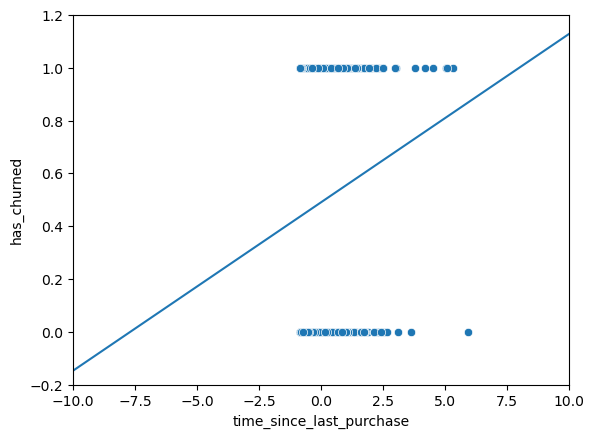

In [9]:
# scatterplot
ax = sns.scatterplot(data=churn, x="time_since_last_purchase", y="has_churned")

# axline is used rather than sns dot regplot so the line isn't limited to the extent of the data
ax.axline(xy1=(0, intercept), slope=slope)

ax.set(xlim=(-10, 10), ylim=(-0.2, 1.2))

plt.show()

All the churn values are zero or one, but the model predictions are fractional. You can think of the predictions as being probabilities that the customer will churn. But the main problem is that the predictions are not constrained to be between zero and one. The plot above shows that the predictions are negative for some customers and exceeds one for some others.

In cases such as this we use a **logistic regression** model. The logistic regression model is a generalized linear model that uses the logistic function to model a binary response variable.

Logistic regression is a statistical model that can be used to predict the probability of a binary outcome. It is a popular machine learning algorithm that is used in a variety of applications, such as spam filtering, fraud detection, and medical diagnosis.

Logistic regression works by fitting a logistic function to the data. The logistic function is a sigmoid function that takes a real number as input and outputs a probability value between 0 and 1.

The logistic function is "S" shaped whereas the linear function is a straight line.

> To create a logistic regression model we use the `statsmodels.formula.api.logit` function. The syntax is similar to that of the `ols` function. The response variable is specified on the left side of the `~` symbol and the explanatory variables are specified on the right side. The `data` argument is used to specify the data frame that contains the variables. To fit/train the model we use the `fit` method.

In [10]:
mdl_churn_vs_recency_logit = smf.logit(
    "has_churned ~ time_since_last_purchase", data=churn
).fit()

Optimization terminated successfully.
         Current function value: 0.683000
         Iterations 4


In [11]:
mdl_churn_vs_recency_lin.params

Intercept                   0.490780
time_since_last_purchase    0.063783
dtype: float64

The model parameters has different meaning than the linear regression model parameters even though the coefficient values are the same.

To visualize the logistic regression model we can use the `sns.regplot()` function with `logistic=True`.

In [12]:
prediction_data = pd.DataFrame({"time_since_last_purchase": np.arange(-20, 21)})

In [13]:
prediction_data = prediction_data.assign(
    has_churned=mdl_churn_vs_recency_logit.predict(
        prediction_data.time_since_last_purchase
    )
)

In [14]:
prediction_data.head(2)

,time_since_last_purchase,has_churned
0,-20,0.004411
1,-19,0.005765


In [15]:
prediction_data.tail(2)

,time_since_last_purchase,has_churned
39,19,0.993819
40,20,0.995271


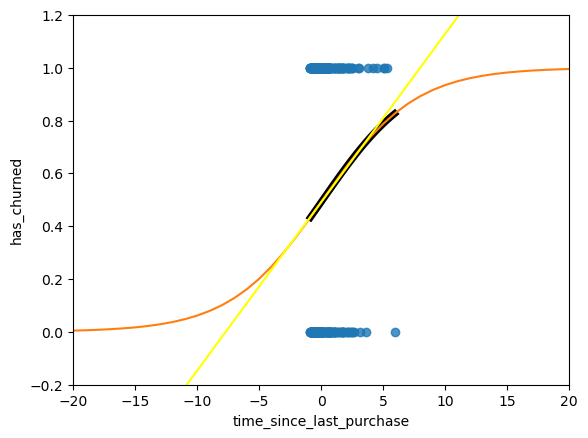

In [16]:
ax = sns.regplot(
    data=churn,
    x="time_since_last_purchase",
    y="has_churned",
    ci=None,
    logistic=True,
    line_kws=({"color": "black", "linewidth": 5}),
)
# full length sigmoid function overlaid on the regplot
sns.lineplot(x="time_since_last_purchase", y="has_churned", data=prediction_data, ax=ax)
# linear regression line overlaid on the regplot
ax.axline(xy1=(0, intercept), slope=slope, color="yellow")

ax.set(xlim=(-20, 20), ylim=(-0.2, 1.2))
plt.show()

The logistic regression curve never goes below zero or above one. To interpret this curve, when the standardized time since last purchase is very small, the probability of churning is close to zero. When the time since last purchase is very high, the probability is close to one. That is, customers who recently bought things are less likely to churn. 

### <a id='toc2_1_'></a>[Representing the logistic regression prediction on different scales](#toc0_)

In [17]:
prediction_data = pd.DataFrame({"time_since_last_purchase": np.arange(-5, 10, 0.25)})
prediction_data = prediction_data.assign(
    has_churned=mdl_churn_vs_recency_logit.predict(
        prediction_data.time_since_last_purchase
    )
)

#### <a id='toc2_1_1_'></a>[-> Expressing the prediction as a probability](#toc0_)

We've already seen this in the previous sections.

<Axes: xlabel='time_since_last_purchase', ylabel='has_churned'>

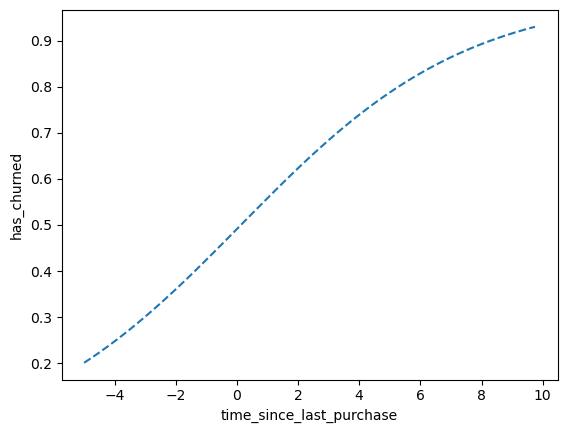

In [18]:
sns.lineplot(
    data=prediction_data, x="time_since_last_purchase", y="has_churned", linestyle="--"
)

#### <a id='toc2_1_2_'></a>[-> Expressing the prediction as most likely outcome](#toc0_)

This is nothing but rounding the probability to the nearest integer.

In [19]:
prediction_data["most_likely_outcome"] = np.round(prediction_data["has_churned"])

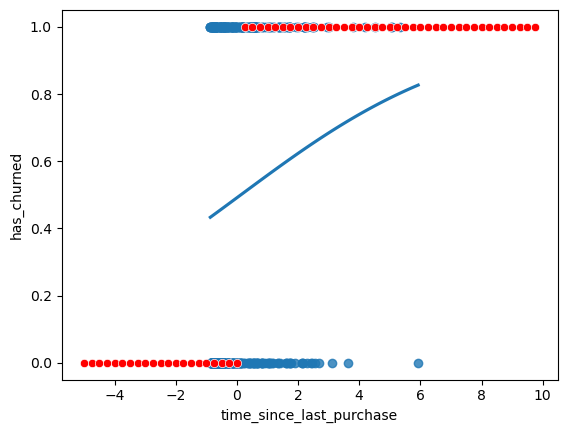

In [20]:
sns.regplot(
    data=churn, x="time_since_last_purchase", y="has_churned", ci=None, logistic=True
)

sns.scatterplot(
    data=prediction_data,
    x="time_since_last_purchase",
    y="most_likely_outcome",
    color="red",
)
plt.show()

#### <a id='toc2_1_3_'></a>[-> Odds ratio](#toc0_)

There is another way to talk about binary responses, commonly used in gambling. 

The odds ratio is the probability that something happens, divided by the probability that it doesn't. 

$$ Odds\ ratio  = \frac{probability\ of \ success}{1 - probability\ of\ success}$$

For example, a probability of 0.25 is the same as the odds of "three to one against", because the probability of the event not happening is 0.75, which is three times as much.

Odds ratios provide an alternative to probabilities that make it easier to compare positive and negative responses.

In [21]:
prediction_data["odds_ratio"] = prediction_data["has_churned"] / (
    1 - prediction_data["has_churned"]
)

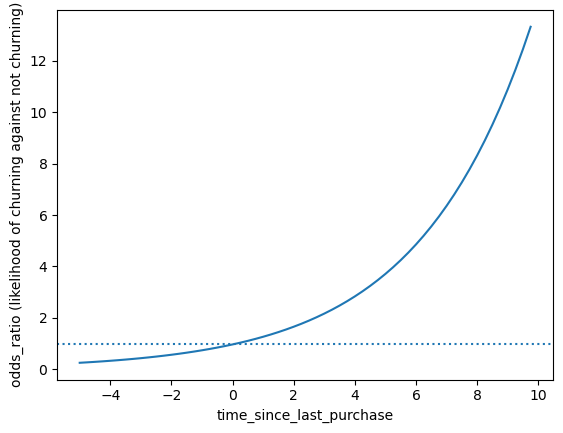

In [22]:
ax = sns.lineplot(data=prediction_data, x="time_since_last_purchase", y="odds_ratio")
ax.axhline(y=1, linestyle=":")
ax.set(ylabel="odds_ratio (likelihood of churning against not churning)")
plt.show()

Here, the dotted line (where the odds ratio = 1) indicates where churning is just as likely as not churning (as, odds ratio = probability of success / probability of failure). Ironically here, success is churning, and failure is not churning.

In the bottom-left, the predictions are below one, so the chance of churning is less than the chance of not churning. In the top-right, the chance of churning is about 13 times more than the chance of not churning.

#### <a id='toc2_1_4_'></a>[-> Log odds ratio](#toc0_)

One nice property of logistic regression odds ratios is that on a log-scale, they change linearly with the explanatory variable. The linear relationship between predicted log odds ratio and the explanatory variable makes changes easier to reason about.

In [23]:
prediction_data["log_odds_ratio"] = np.log(prediction_data["odds_ratio"])

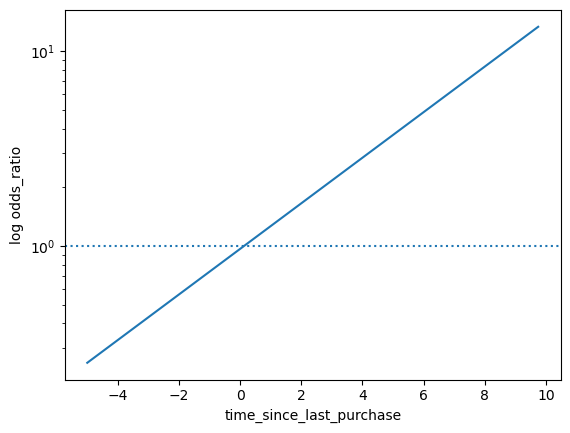

In [24]:
ax = sns.lineplot(data=prediction_data, x="time_since_last_purchase", y="odds_ratio")
ax.axhline(y=1, linestyle=":")
ax.set(yscale="log", ylabel="log odds_ratio")
plt.show()

In [25]:
prediction_data.head()

,time_since_last_purchase,has_churned,most_likely_outcome,odds_ratio,log_odds_ratio
0,-5.00,0.200833,0.0,0.251303,-1.381094
1,-4.75,0.211853,0.0,0.268799,-1.313790
2,-4.50,0.223309,0.0,0.287513,-1.246487
3,-4.25,0.235199,0.0,0.307530,-1.179183
4,-4.00,0.247521,0.0,0.328940,-1.111879


#### <a id='toc2_1_5_'></a>[-> Comparing scales](#toc0_)

Scale | Are values easy to interpret? | Are changes easy to interpret? | Is precise
------|-------------------------------|--------------------------------|------------
Probability | Yes | No | Yes
Most likely outcome | Yes | Yes | No
Odds ratio | Yes | No | Yes
Log odds ratio | No | Yes | Yes

### <a id='toc2_2_'></a>[Quantifying logistic regression model fit](#toc0_)

The use of evaluation metrics is crucial in verifying that the model is functioning properly and appropriately. Some of the metrics that are commonly used for evaluating a logistic regression model are discussed below. 

#### <a id='toc2_2_1_'></a>[-> Confusion matrix](#toc0_)

**Confusion matrix:** A confusion matrix is a table that visualizes the performance of a classification/logistic regression model by comparing the predicted classes with the actual classes. A confusion matrix has four main components: *True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN)*.

The confusion matrix allows one to assess the model's performance by analyzing these four components. The confusion matrix acts as the foundation for various other evaluation metrics such as accuracy, precision, recall, F1 score etc. 

For a simple logistic regression model, the 4 components of the confusion matrix are also the 4 possible outcomes of the model. 

" "  | Predicted False | Predicted True
----|----------------|---------------
**Actual False** | True Negative (TN) | False Positive (FP)
**Actual True** | False Negative (FN) | True Positive (TP)

- Getting the confusion matrix elements manually -

In [26]:
# in a logistic regression model to get the predictions on the original data
# call .predict() with no arguments and then get the rounded values
churn["has_churned_predictions"] = np.round(mdl_churn_vs_recency_logit.predict())

In [27]:
churn.groupby(["has_churned", "has_churned_predictions"]).size()

has_churned  has_churned_predictions
0            0.0                        141
             1.0                         59
1            0.0                        111
             1.0                         89
dtype: int64

- Get the confusion matrix elements using the `fitted_logit_model.pred_table()` method.

In [28]:
churn_logit_cnf = mdl_churn_vs_recency_logit.pred_table()

In [29]:
churn_logit_cnf

array([[141.,  59.],
       [111.,  89.]])

- Visualizing the confusion matrix using the `sns.heatmap()` function with `annot=True`.

<Axes: >

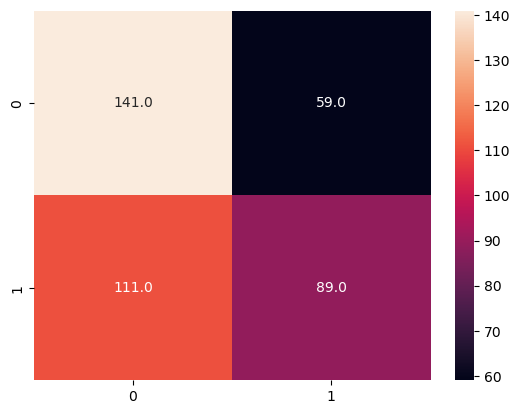

In [30]:
sns.heatmap(churn_logit_cnf, annot=True, fmt="")

- Visualizing the confusion matrix using the `statsmodels.graphics.mosaicplot.mosaic()` function.

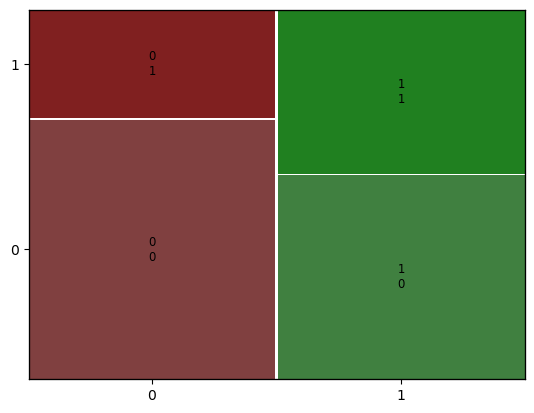

In [31]:
# Import mosaic from statsmodels.graphics.mosaicplot
from statsmodels.graphics.mosaicplot import mosaic

# Draw a mosaic plot of conf_matrix
mosaic(churn_logit_cnf)
plt.show()

#### <a id='toc2_2_2_'></a>[-> Accuracy](#toc0_)

**Accuracy:** Accuracy is a commonly used metric that measures the overall correctness of a model's predictions.
$$Accuracy = (TP + TN) / (TP + TN + FP + FN)$$


In [32]:
TN, FN, FP, TP = (
    churn_logit_cnf[0, 0],
    churn_logit_cnf[0, 1],
    churn_logit_cnf[1, 0],
    churn_logit_cnf[1, 1],
)

In [33]:
churn_logit_acc = (TP + TN) / (TP + TN + FP + FN)

In [34]:
churn_logit_acc

0.575

#### <a id='toc2_2_3_'></a>[-> Precision](#toc0_)

**Precision:** the proportion of *correctly predicted positive* instances *out of all instances predicted as positive*. It is a useful metric when the cost of false positives is high.
$$Precision = TP / (TP + FP)$$


In [35]:
churn_logit_pre = TP / (TP + FP)

In [36]:
churn_logit_pre

0.445

#### <a id='toc2_2_4_'></a>[-> Recall/Sensitivity](#toc0_)

**Recall/Sensitivity:** measures the proportion of *correctly predicted positive* instances *out of all actual positive* instances. It is particularly useful when the cost of false negatives is high.
$$Recall = TP / (TP + FN) $$


In [37]:
churn_logit_sen = TP / (TP + FN)

In [38]:
churn_logit_sen

0.6013513513513513

#### <a id='toc2_2_5_'></a>[-> Specificity](#toc0_)

**Specificity:** measures the proportion of *correctly predicted negative* instances *out of all actual negative* instances.
$$Specificity = TN / (TN + FP) $$

In [39]:
churn_logit_spe = TN / (TN + FP)

In [40]:
churn_logit_spe

0.5595238095238095

#### <a id='toc2_2_6_'></a>[-> F1 score](#toc0_)

**F1 score:** the harmonic mean of precision and recall. It is a useful metric when the classes are imbalanced.
$$F1\ score = 2 * (Precision * Recall) / (Precision + Recall)$$

In [41]:
churn_logit_f1 = (
    2 * (churn_logit_pre * churn_logit_sen) / (churn_logit_pre + churn_logit_sen)
)

In [42]:
churn_logit_f1

0.5114942528735632